# Inception Model

In [1]:
import tensorflow as tf

import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Tune Hyperparameters

In [2]:
batch_size = 32
epochs = 5
filter_size = 3
group_1_dim = 32
group_2_dim = 64
group_3_dim = 128
dense_dim = 1024

dropout_rate = 0.2

### Load Data
Change to your directory

In [72]:
train_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="training",
                                                 seed=123)

val_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=123)

test_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\test", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size)

test_ds_no_pre = test_ds

class_names = train_ds.class_names
print(class_names)

Found 89663 files belonging to 10 classes.
Using 71731 files for training.
Found 89663 files belonging to 10 classes.
Using 17932 files for validation.
Found 9966 files belonging to 10 classes.
['arts, crafts & sewing', 'books', 'clothing, shoes & jewelry', 'electronics', 'grocery & gourmet food', 'health & personal care', 'musical instruments', 'patio, lawn & garden', 'sports & outdoors', 'toys & games']


### Verify Distribution of Data

In [4]:
count = np.zeros(10, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print(count)

[7171 7187 7006 7269 7187 7143 7162 7188 7085 7333]


### Preprocess Data

In [73]:
def preprocess_data(X, Y):
  """
  Method:
      pre-processes the data for your model.
  """
  X_p = tf.keras.applications.inception_v3.preprocess_input(X)
  Y_p = tf.one_hot(Y, 10)

  return X_p, Y_p

train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)
test_ds = test_ds.map(preprocess_data)

### Define Model Architecture

In [91]:
base_inception = InceptionV3(include_top=False, input_shape=(299, 299, 3))

input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
resizing_layer = tf.keras.layers.Lambda(lambda image: tf.keras.preprocessing.image.smart_resize(image,(299, 299)))(input_layer)
inception_layers = base_inception(resizing_layer, training=False)
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(inception_layers)
dense_layer = tf.keras.layers.Dense(500, activation='relu')(pooling_layer)
dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
output_layer =  tf.keras.layers.Dense(10, activation='softmax')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

### Define Top 3 and Top 2 Metrics

In [7]:
import functools
top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'
top2_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

### Training (without inception)

In [8]:
# Freeze the inception layers
base_inception.trainable = False

model.compile(tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', top3_acc])

with tf.device('/gpu:0'):
        history = model.fit(
                train_ds,
                validation_data=val_ds,
                batch_size=300,
                epochs=4,
                verbose=1)

results = model.evaluate(test_ds)

Epoch 1/4
2242/2242 [==============================] - 307s 131ms/step - loss: 1.4437 - accuracy: 0.5059 - top3_acc: 0.7794 - val_loss: 1.3016 - val_accuracy: 0.5509 - val_top3_acc: 0.8179
Epoch 2/4
2242/2242 [==============================] - 300s 134ms/step - loss: 1.3307 - accuracy: 0.5469 - top3_acc: 0.8112 - val_loss: 1.2863 - val_accuracy: 0.5520 - val_top3_acc: 0.8234
Epoch 3/4
2242/2242 [==============================] - 302s 135ms/step - loss: 1.2858 - accuracy: 0.5617 - top3_acc: 0.8238 - val_loss: 1.2550 - val_accuracy: 0.5684 - val_top3_acc: 0.8304
Epoch 4/4
312/312 [==============================] - 34s 110ms/step - loss: 1.3101 - accuracy: 0.5544 - top3_acc: 0.8180


### Train inception layers

In [9]:
# Unfreeze inception layers
for layer in base_inception.layers[:164]:
  layer.trainable=False

for layer in base_inception.layers[164:]:
  layer.trainable=True

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc, top2_acc])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 3, restore_best_weights = False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(r'C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\image\gln_checkpoint_top3.keras', 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=32,
        epochs=1000,
        verbose=1,
        callbacks=[early_stop, checkpoint])

results = model.evaluate(test_ds)


Epoch 1/1000
2242/2242 [==============================] - ETA: 0s - loss: 1.2241 - accuracy: 0.5790 - top3_acc: 0.8368 - top2_acc: 0.7504
Epoch 1: val_loss improved from inf to 1.24627, saving model to C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\image\gln_checkpoint_top3.keras
2242/2242 [==============================] - 308s 136ms/step - loss: 1.2241 - accuracy: 0.5790 - top3_acc: 0.8368 - top2_acc: 0.7504 - val_loss: 1.2463 - val_accuracy: 0.5708 - val_top3_acc: 0.8343 - val_top2_acc: 0.7446
Epoch 2/1000
2242/2242 [==============================] - ETA: 0s - loss: 1.1978 - accuracy: 0.5884 - top3_acc: 0.8434 - top2_acc: 0.7594
Epoch 2: val_loss improved from 1.24627 to 1.23863, saving model to C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\image\gln_checkpoint_top3.keras
2242/2242 [==============================] - 303s 135ms/step - loss: 1.1978 - accuracy: 0.5884 - top3_acc: 0.8434 - top2_acc: 0.7594 - val_loss: 1.2386 - val_accuracy: 0.5

### Examine Prediction Output

In [60]:
import pandas as pd

# Skip training, load model
custom_objects = {'top3_acc':top3_acc, 'top2_acc':top2_acc}
model = tf.keras.models.load_model(r"C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\image\gln_model.h5", custom_objects=custom_objects)

predictions = model.predict(test_ds)
print(predictions)

# Softmax to one-hot
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

[[4.4064674e-01 1.7415144e-02 5.5290837e-02 ... 6.5852560e-02
  2.0364128e-02 8.5438989e-02]
 [3.4151848e-02 1.2842260e-05 4.0782890e-03 ... 1.7119743e-01
  5.3330505e-01 1.9499995e-02]
 [3.5087056e-02 5.0001938e-05 4.8411456e-03 ... 3.4039554e-01
  2.0261040e-01 2.5467655e-02]
 ...
 [1.5169968e-01 1.1424039e-03 7.6361764e-03 ... 2.8484932e-01
  1.7979848e-01 1.7292096e-01]
 [4.4727054e-01 1.9800054e-05 4.1591623e-01 ... 1.0015340e-02
  7.5596524e-03 8.8957168e-02]
 [7.3739551e-02 3.9137363e-01 6.9886062e-04 ... 2.6298966e-02
  1.2502935e-02 2.3170987e-02]]
[0 8 7 ... 7 0 1]


### Confusion Matrix

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[5 4 3 ... 9 0 0]


<Axes: xlabel='Predicted Label', ylabel='True Label'>

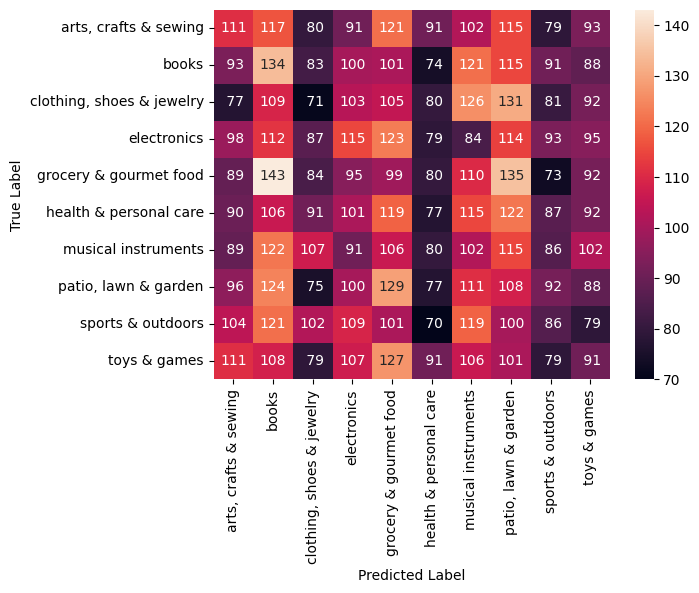

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create a confusion matrix
y_test = np.concatenate([y for x, y in test_ds], axis=0)
print(y_test)
y_test =np.argmax(y_test, axis=1)
print(y_test)

cm = confusion_matrix(y_test, predicted_labels)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(cm, index=class_names, columns=class_names)
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt='3g')

### Compare to CNN
See if an image that's misclassified by the CNN can be correctly classified by CNN+Inception model

(CNN predicted as 'patio, lawn & garden')

The model predicted this image to be toys & games


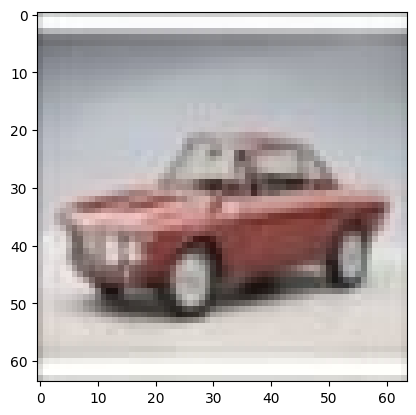

In [68]:
from PIL import Image
import matplotlib.pyplot as plt

car = Image.open(r"C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\data\img\car_1.jpg")
plt.imshow(car)

n = np.array(car)
p = n.reshape(1, 64, 64, 3)
car_preproccess = tf.keras.applications.inception_v3.preprocess_input(p)

prediction = model.predict(car_preproccess)
prediction = np.argmax(prediction)
prediction = class_names[prediction]

print("The model predicted this image to be", prediction)

### Test CNN+Inception on Various Images

Prediction: musical instruments
True Label: musical instruments


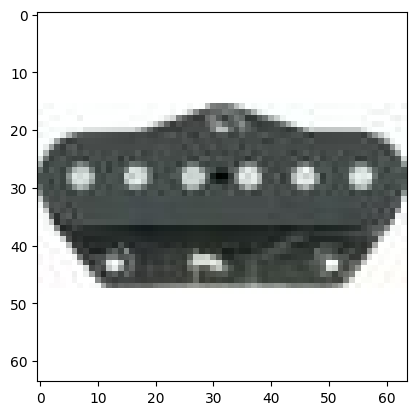

In [90]:
labels =['arts, crafts & sewing', 'books', 'clothing, shoes & jewelry', 'electronics', 'grocery & gourmet food',  
         'health & personal care', 'musical instruments', 'patio, lawn & garden', 'sports & outdoors', 'toys & games']
 
image_number = 0
 
first_element = test_ds_pre.take(1)
for image, label in first_element:
  n = np.array(image[0].numpy().astype("uint8"))
  p = n.reshape(1, 64, 64, 3)
  plt.imshow(p[0].astype("uint8"))
  predicted_label = labels[model.predict(tf.keras.applications.inception_v3.preprocess_input(p)).argmax()]
 
original_label = labels[label[image_number].numpy()]
 
print(f"Prediction: {predicted_label}")
print(f"True Label: {original_label}")